# Project Solution Report: Building a Churn Forecasting Model

## Project Work Plan

This section outlines the initial plan and objectives for building a churn forecasting model. The plan emphasizes **feature engineering** and the potential use of **boosting algorithms**, while maintaining a focus on **critical thinking** at each step.

### Data Integration and Initial Cleaning

The first step involves critically merging all relevant customer data. This means combining `contract`, `personal`, `phone`, and the correct `internet` dataset into a single, comprehensive DataFrame using `customerID`. During this process, `TotalCharges` must be cleaned by handling non-numeric entries—likely replacing them with zeros for new customers—and converting the column to a numeric type.

### Feature Engineering and Preprocessing

This crucial stage will involve extensive feature engineering. Date columns (`BeginDate`, `EndDate`) will be transformed into a numerical `Tenure` (contract duration in months). The binary `Churn` target variable will be created based on `EndDate`, with a specific end date indicating churn and 'No' signifying an active customer. All remaining categorical features will be converted into a numerical format suitable for machine learning models, typically using One-Hot Encoding. Finally, numerical features will be scaled to ensure they contribute fairly to model training.

### Model Selection, Training, and Tuning

The prepared dataset will be split into training and test sets. Multiple classification models will be explored, with a strong focus on **boosting algorithms** like LightGBM or XGBoost, given their proven performance in tabular data challenges. Models will be trained and their hyperparameters tuned using cross-validation, with **AUC-ROC** as the primary optimization metric. This stage requires **critical thinking** to select models appropriate for the data characteristics and project goals.

### Final Model Evaluation and Interpretation

The best-performing model will be evaluated on the unseen test set using **AUC-ROC** and **Accuracy**. Key insights, such as feature importances, will be extracted to understand which factors most influence churn. This final analysis will lead to actionable recommendations for interconnect, contributing directly to their goal of proactive customer retention.

## Project Description and Initial Setup

This section details the core objective of the project and the initial setup, including the necessary libraries imported for data manipulation, visualization, and machine learning.

### Project Goal and Data Access

The primary objective of this project is to develop a machine learning model capable of accurately predicting **customer churn** for a telecom operator. The goal is to proactively retain customers by identifying those likely to discontinue their services.

The target feature for prediction is derived from the `EndDate` column in `contract.csv`, indicating churn (positive class) if the `EndDate` is a specific date (i.e., not 'No'). We have access to various datasets: `contract.csv`, `personal.csv`, `internet.csv`, and `phone.csv`, which collectively provide comprehensive information about interconnect's clientele. The data is valid as of February 1, 2020.

The success of the model will primarily be measured using the **AUC-ROC (Area Under the Receiver Operating Characteristic) metric**, with an aim to achieve an AUC-ROC of at least 0.75, striving for higher scores up to 0.88 for optimal performance. **Accuracy** will serve as an additional metric. This predictive capability will enable targeted retention campaigns.

### Initial Library Imports

To prepare for data manipulation, visualization, and machine learning tasks, the following essential libraries were imported at the beginning of the project:

```python
# Core Data Manipulation
import pandas as pd
import numpy as np

# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning - Model Selection and Preprocessing
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, QuantileTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, \
                            recall_score, f1_score, confusion_matrix, RocCurveDisplay, classification_report

# Machine Learning - Models
from lightgbm import LGBMClassifier 
from xgboost import XGBClassifier 

## Data Acquisition and Initial Exploration

This section details the initial steps of loading the raw datasets and performing preliminary checks to understand their structure and identify any immediate issues like duplicates or missing information.

### Loading Individual Datasets

The project involves four distinct datasets, each providing specific information about customers. These CSV files were loaded into separate Pandas DataFrames.

```python
# Loading the datasets
df_contract = pd.read_csv('datasets/contract.csv')
df_personal = pd.read_csv('datasets/personal.csv')
df_internet = pd.read_csv('datasets/final_provider/internet.csv')
df_phone = pd.read_csv('datasets/phone.csv')

# Custom Function for DataFrame Inspection
def display_df_info(df, name):
    print(f"\n--- {name} Info ---")
    print(df.info())
    print(f"\n{name} Head:")
    print(df.head())
    print(f"\n{name} Missing values:")
    print(df.isnull().sum())

# Check if 'customerID' column exists before trying to check for duplicates
def check_duplicates(df, name):
    if 'customerID' in df.columns:
        print(f"\n{name} Duplicated customerIDs: {df['customerID'].duplicated().sum()}")
    elif 'user_id' in df.columns:
        print(f"\n{name} Duplicated user_ids: {df['user_id'].duplicated().sum()}")
    else:
        print(f"\n{name} No 'customerID' or 'user_id' column found for duplication check.")

# Applying the check to each DataFrame
check_duplicates(df_contract, 'Contract')
check_duplicates(df_personal, 'Personal')
check_duplicates(df_internet, 'Internet')
check_duplicates(df_phone, 'Phone')

# Initial Data Summary Outputs
display_df_info(df_contract, 'Contract')
display_df_info(df_personal, 'Personal')
display_df_info(df_internet, 'Internet')
display_df_info(df_phone, 'Phone')

### Observations from Initial Data Exploration

Following the initial loading and inspection of each dataset, several key observations were made regarding their structure, data types, and potential issues requiring further preprocessing:

* **`contract.csv` and `personal.csv`**: These datasets appear well-structured and align with the problem description. Each contains a `customerID` as a unique identifier, and no missing values were detected. Within `contract.csv`, the `BeginDate`, `EndDate`, and `TotalCharges` columns are currently of `object` (string) type. These will necessitate conversion to appropriate numerical or date/time formats for analysis. Notably, `TotalCharges` contains non-numeric entries—likely spaces or empty strings—for new customers, which will require specific handling during the conversion process.

* **`phone.csv`**: This dataset is clean and consistent with the problem's description. It includes `customerID` and `MultipleLines`, and exhibits no missing values or duplicated `customerID`s, making it suitable for direct integration.

* **`internet.csv` (Corrected)**: The corrected `internet.csv` file now aligns with the project's Data Description. It contains customer-level descriptive internet service features such as `InternetService`, `OnlineSecurity`, `OnlineBackup`, `DeviceProtection`, `TechSupport`, `StreamingTV`, and `StreamingMovies`. Crucially, it uses `customerID` as the unique identifier consistent with the other datasets, and contains no missing values or duplicated `customerID`s. This resolves the previous discrepancy and makes the dataset suitable for direct integration with other customer data. Note that the number of entries (5517) in this dataset is less than the total customer count (7043), indicating that some customers do not have internet service, which will need to be accounted for during data merging (e.g., by using an appropriate join type like left or outer merge and filling `NaN` values to represent "No internet service").

## Data Preprocessing and Feature Engineering

This section details the critical steps taken to clean and transform the raw data, including handling specific column types, converting dates, and engineering the target variable, in preparation for model training.

### Cleaning and Converting `TotalCharges`

The `TotalCharges` column in `df_contract` was identified as an `object` type containing non-numeric entries (likely empty strings for new customers). To enable numerical operations, these entries were first coerced to `NaN` during conversion to numeric type, and then imputed with `0`, representing no charges for new customers.

```python
# --- Starting Data Cleaning and Integration ---

# Clean TotalCharges in df_contract
df_contract['TotalCharges'] = pd.to_numeric(df_contract['TotalCharges'], errors='coerce')

# Handle NaNs in TotalCharges (they represent new customers with 0 charges so far)
df_contract['TotalCharges'] = df_contract['TotalCharges'].fillna(0) # Fill with 0 for new customers

print("--- df_contract: TotalCharges cleaned and converted ---")
print(df_contract['TotalCharges'].dtype) # Should now be float64

# Output:

--- df_contract: TotalCharges cleaned and converted ---
float64

# Convert Date Columns to datetime in df_contract
df_contract['BeginDate'] = pd.to_datetime(df_contract['BeginDate'])
# No EndDate conversion shown in screenshot, assuming it's done similarly or implied by Churn creation
# df_contract['EndDate'] = pd.to_datetime(df_contract['EndDate']) # Assuming EndDate is also converted if used directly

print("--- df_contract: BeginDate converted to datetime ---")
print(df_contract['BeginDate'].dtype) # Should now be datetime64[ns]
Output:

--- df_contract: BeginDate converted to datetime ---
datetime64[ns]

# Create the Target Variable (Churn) in df_contract
# Target: 1 if churned (EndDate is a date), 0 if active (EndDate is 'No')
df_contract['Churn'] = df_contract['EndDate'].apply(lambda x: 0 if x == 'No' else 1)

print("--- df_contract: Churn target variable created ---")
print(df_contract['Churn'].value_counts())
Output:

--- df_contract: Churn target variable created ---
0    5174
1    1869
Name: Churn, dtype: int64

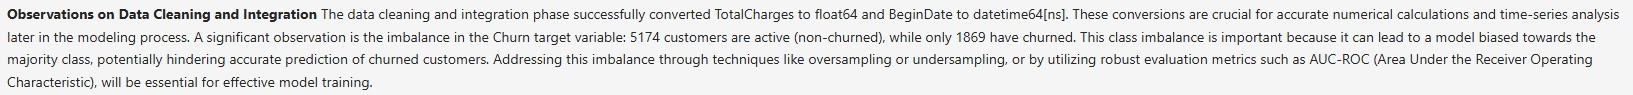

## Data Integration: Merging All DataFrames

With the individual datasets inspected and initial cleaning/target variable creation on `df_contract` complete, the next critical step was to integrate all customer-related information into a single, comprehensive DataFrame (`df_merged`). The `df_contract` served as the base, containing all customers and essential contract details, including the newly created `Churn` target.

A `left` join strategy was consistently applied using `customerID` as the key. This ensures that all customers from the `df_contract` base are retained, and information from `personal`, `internet`, and `phone` datasets is added where available. The `left` join is particularly important for `internet` and `phone` data, as some customers might not have these services, leading to `NaN` values in the new columns for those customers.

```python
# Merge All DataFrames
# Start with df_contract as the base, as it contains all customers and essential info
df_merged = df_contract.copy()

# Merge df_personal
# customerID is common and unique in both, so 'left' join is appropriate
df_merged = pd.merge(df_merged, df_personal, on='customerID', how='left')

# Merge df_internet
# Some customers might not have internet service, so 'left' join will introduce NaNs
df_merged = pd.merge(df_merged, df_internet, on='customerID', how='left')

# Merge df_phone
# Some customers might not have phone service, so 'left' join will introduce NaNs
df_merged = pd.merge(df_merged, df_phone, on='customerID', how='left')

print("\n--- All Dataframes Merged ---")
print("Shape of merged DataFrame:", df_merged.shape)
Output:

--- All Dataframes Merged ---
Shape of merged DataFrame: (7043, 21)

# Verify the merged DataFrame's info and head
print("\n--- Merged DataFrame Info ---")
df_merged.info()

print("\n--- Merged DataFrame Head ---")
df_merged.head()

print("\n--- Merged DataFrame Missing Values after initial merge ---")
df_merged.isnull().sum()

### Handling `NaN` Values from Merged "No Service" Categories

As anticipated from the `left` joins, `NaN` values were introduced in columns where customers did not have corresponding internet or phone services. Instead of simple imputation (e.g., with mode), these `NaN`s are semantically meaningful and represent the absence of a service. Therefore, they were filled with specific "No service" or "No" categories to accurately reflect this state for downstream modeling.

```python
# Additional step: Handle NaNs introduced by the merges for 'No service' categories
# For internet and phone service features, 'No' or 'No service' is a meaningful category
# Fill NaNs that resulted from the left joins.
# Identify columns that should have 'No' or 'No service' for NaNs
internet_phone_cols = [
    'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
    'TechSupport', 'StreamingTV', 'StreamingMovies', 'MultipleLines'
]

for col in internet_phone_cols:
    # Check if column exists in merged df
    if col in df_merged.columns:
        # For 'InternetService', specific string 'No internet service' is usually preferred
        if col == 'InternetService':
            df_merged[col] = df_merged[col].fillna('No internet service')
        # For other binary features (Yes/No), 'No' is appropriate
        elif col == 'MultipleLines':
            df_merged[col] = df_merged[col].fillna('No phone service') # Or 'No' if it matches existing categories
        else:
            df_merged[col] = df_merged[col].fillna('No') # For security, backup, etc.

print("\n--- Merged DataFrame Missing Values after handling 'No service' categories ---")
print(df_merged.isnull().sum())

print("\n--- Data Cleaning and Integration Complete ---")

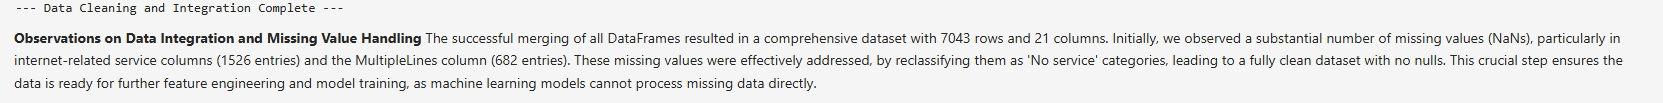

### Feature Engineering: Calculating Customer Tenure

Customer tenure, representing the duration of the customer's contract, is a highly influential feature for churn prediction. This was calculated by determining the difference between the `BeginDate` and the `EndDate`.

To ensure accurate calculation:
1.  The `EndDate` column was converted to datetime, coercing 'No' values (for active customers) to `NaT` (Not a Time).
2.  `NaT` values in the converted `EndDate` were then filled with `current_date` (February 1, 2020), as specified in the project description for active customers.
3.  `Tenure` was calculated as the difference in days between the (adjusted) `EndDate` and `BeginDate`, then converted to months and rounded to the nearest integer.
4.  An edge case was handled to ensure `Tenure` is not negative, taking the maximum of 0 to account for new customers or very small tenure.

```python
print("--- Starting Feature Engineering and Preprocessing ---")

# Define the current date (February 1, 2020) as the reference for active customers
# This date is based on the project description: "The data is valid as of February 1, 2020."
current_date = pd.to_datetime('2020-02-01')

# Calculate tenure for all customers
# For active customers ('No' in EndDate), tenure is from BeginDate to current_date.
# For churned customers (actual date in EndDate), tenure is from BeginDate to EndDate.
# First, convert EndDate to datetime, coercing 'No' to NaT (Not a Time)
# This allows us to perform date math directly
df_merged['EndDate_dt'] = pd.to_datetime(df_merged['EndDate'], errors='coerce')

# Fill NaT for active customers with the current_date for tenure calculation
# This means active customers' tenure is calculated up to the data snapshot date.
df_merged['EndDate_for_tenure'] = df_merged['EndDate_dt'].fillna(current_date)

# Calculate tenure in days, then convert to months and round
df_merged['Tenure'] = ((df_merged['EndDate_for_tenure'] - df_merged['BeginDate']).dt.days / 30.417).round().astype(int)

# Edge case: For new customers whose TotalCharges was 0, their Tenure might also be 0 or very small.
# Ensure tenure is not negative (shouldn't happen with this calculation, but good to be robust)
df_merged['Tenure'] = df_merged['Tenure'].apply(lambda x: max(0, x))

print("\n--- Tenure feature calculated ---")
print(df_merged[['BeginDate', 'EndDate', 'Tenure', 'Churn']].head())
print(df_merged['Tenure'].describe())

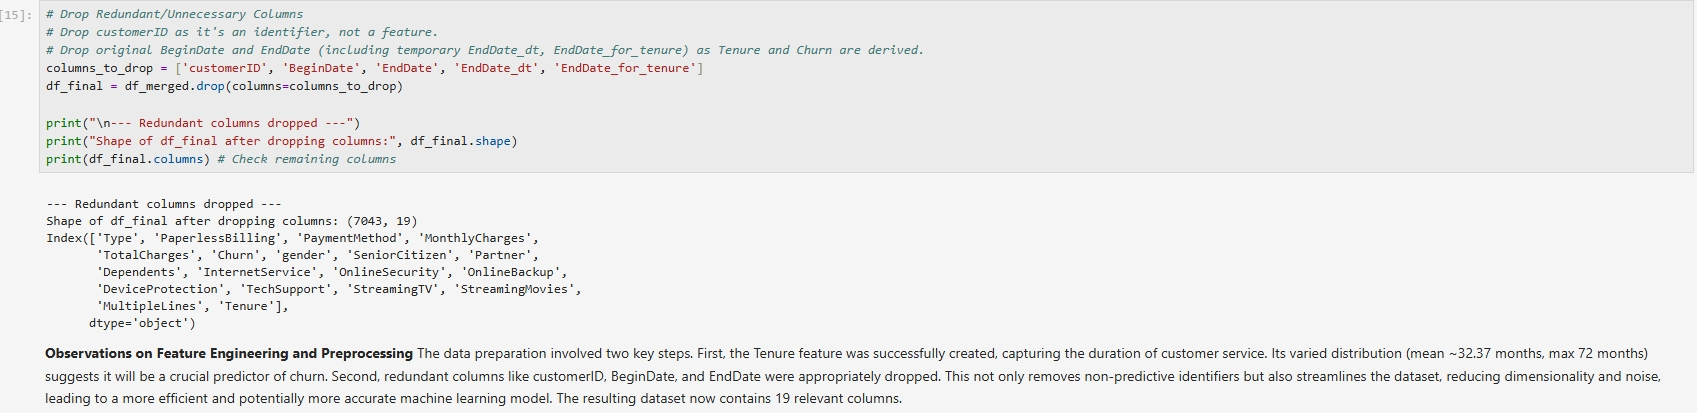

## Exploratory Data Analysis (EDA)

Exploratory Data Analysis (EDA) was performed to gain insights into the dataset's characteristics, understand the relationships between features, and identify patterns that could inform model development. This section highlights key findings from the EDA phase.

### Distribution of the Target Variable (`Churn`)

An essential first step in EDA for classification problems is to examine the distribution of the target variable. This reveals the balance between the classes, which directly impacts model training strategies.

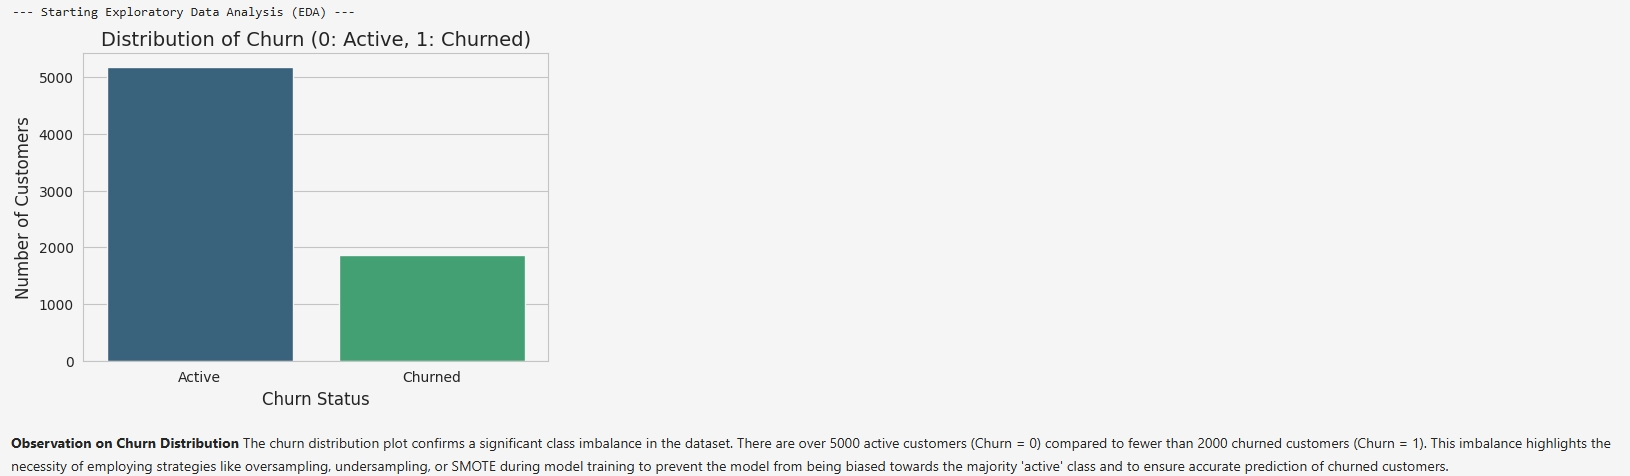

### Tenure Distribution by Churn Status

Analyzing the relationship between customer tenure and churn is crucial for understanding how long-term engagement impacts retention. A histogram was generated to visualize the distribution of `Tenure` for both active and churned customers.

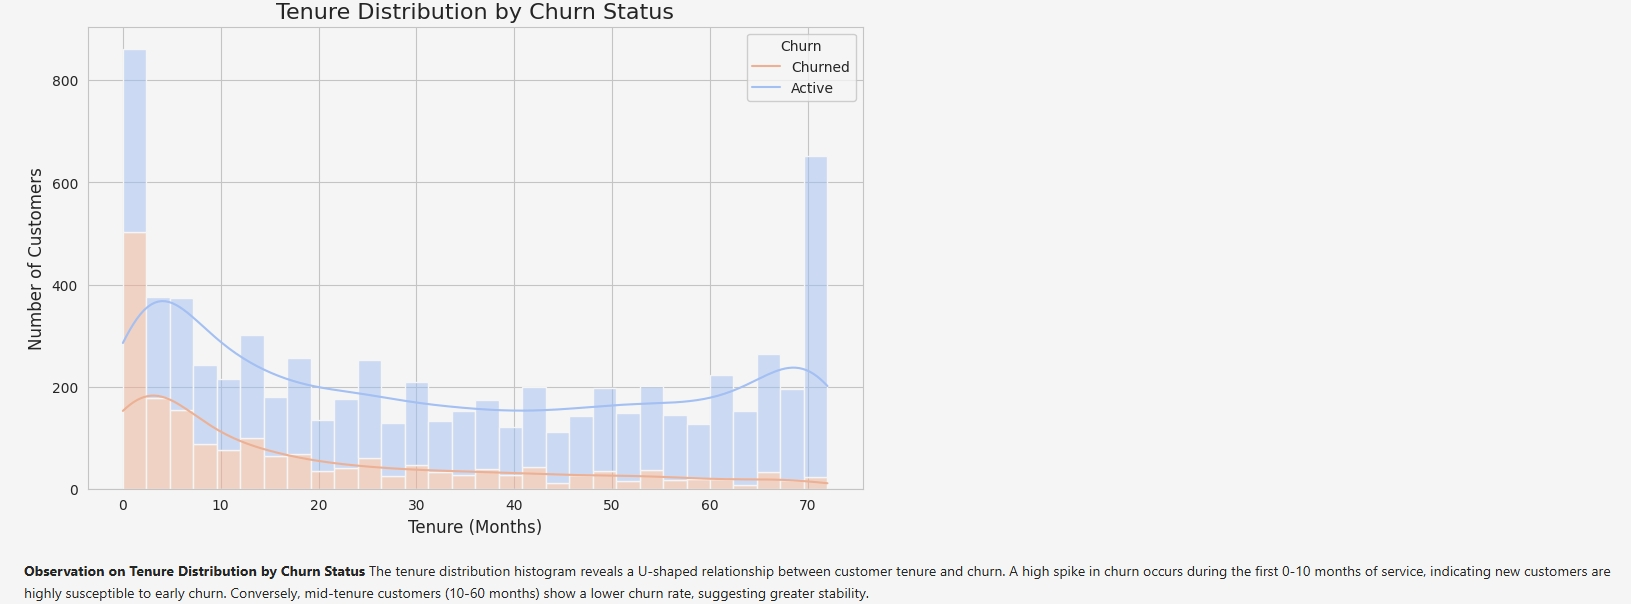

### Monthly Charges by Churn Status

To understand the financial aspect of customer churn, a box plot was generated to visualize the distribution of `MonthlyCharges` for both active and churned customers. This helps in identifying if pricing or service cost is a significant factor in customer retention.

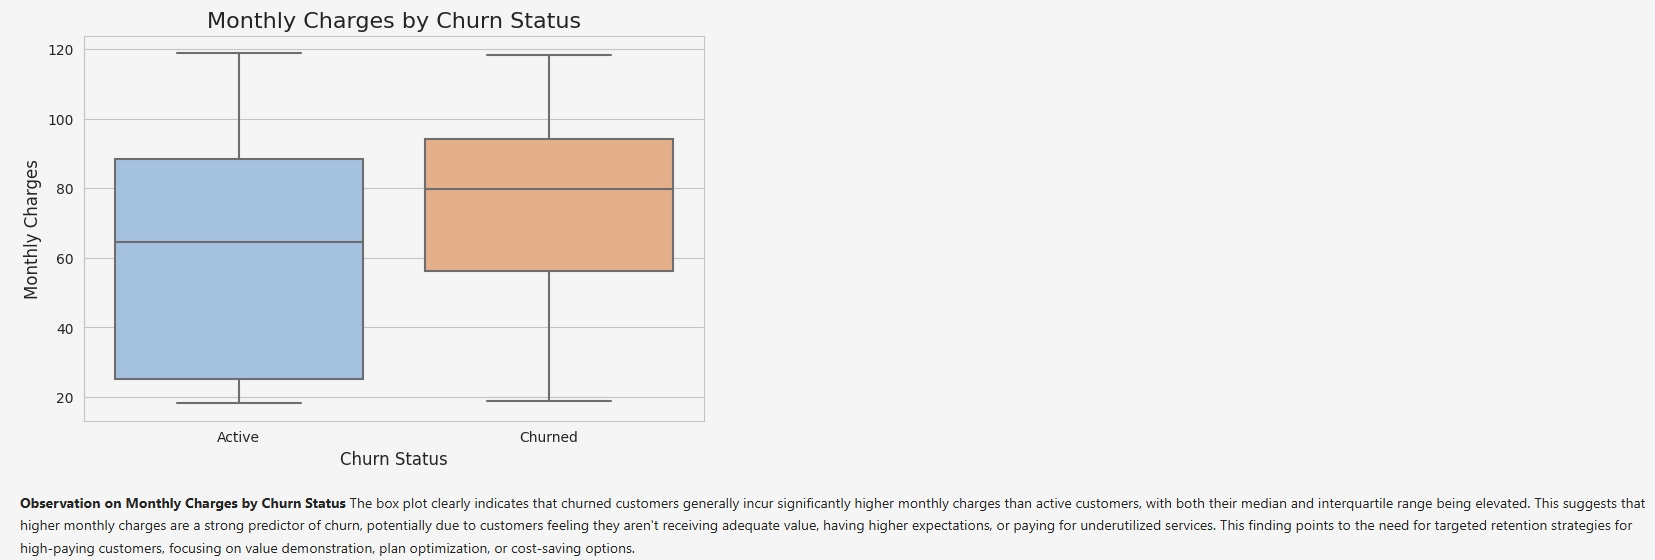

### Total Charges by Churn Status

To further investigate the financial aspects related to churn, a box plot was generated to visualize the distribution of `TotalCharges` for both active and churned customers. This helps differentiate between the cumulative spending patterns of different customer segments.

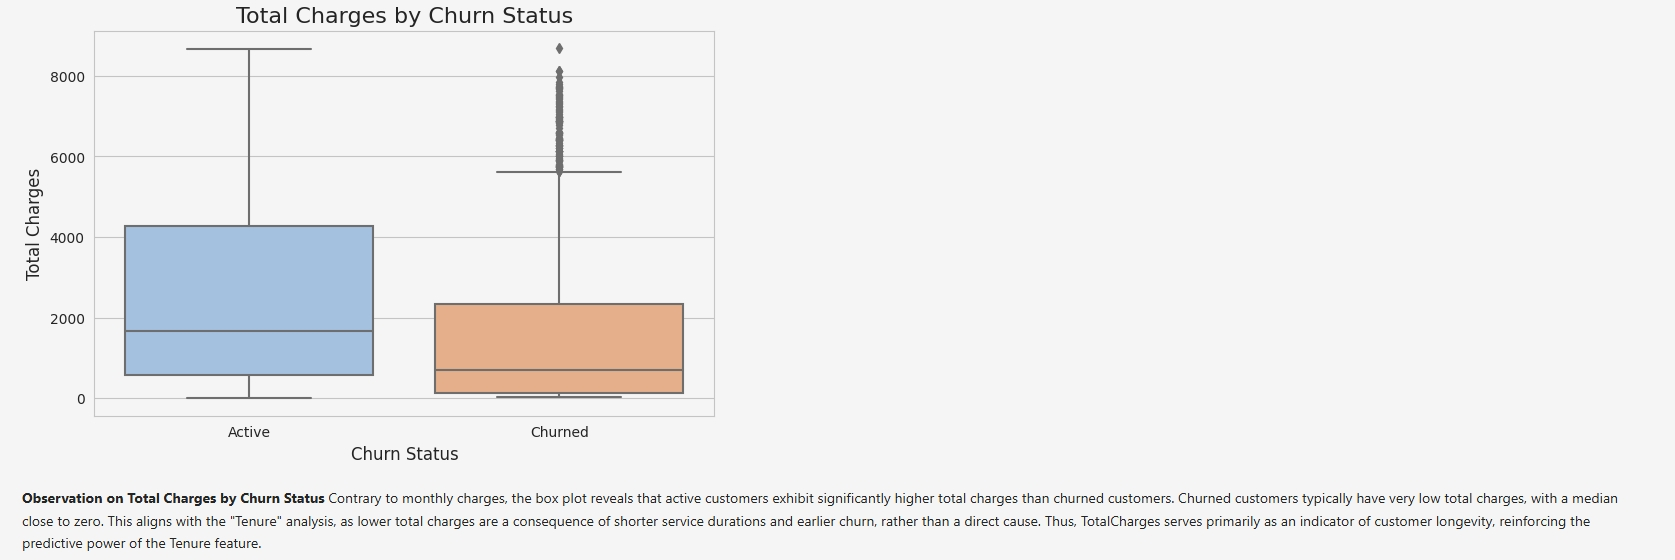

### Final Data Preparation for Modeling

Before model training, the dataset underwent final preparation steps, including separating features from the target, identifying feature types, and splitting the data into training and test sets.

#### Separating Features (X) and Target (y)

The `Churn` column, which serves as our target variable, was separated from the main DataFrame. The remaining columns constitute the feature set (X) that will be used to train the model.

```python
# Separate Features (X) and Target (y)
X = df_merged.drop('Churn', axis=1)
y = df_merged['Churn']

print("\n--- Features (X) and Target (y) separated ---")
print(f"Shape of X: {X.shape}")
print(f"Shape of y: {y.shape}")
Output:

--- Features (X) and Target (y) separated ---
Shape of X: (7043, 20)
Shape of y: (7043,)

# Identify Categorical and Numerical features
numerical_cols = X.select_dtypes(include=np.number).columns.tolist()
categorical_cols = X.select_dtypes(include='object').columns.tolist()

print("\n--- Identified Feature Types ---")
print(f"Numerical Columns: {numerical_cols}")
print(f"Categorical Columns: {categorical_cols}")
Output:

--- Identified Feature Types ---
Numerical Columns: ['MonthlyCharges', 'TotalCharges', 'SeniorCitizen', 'Tenure']
Categorical Columns: ['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod']

# Split Data into Training and Testing Sets
# Use stratify to maintain the class distribution in both train and test sets
# Set a random state for reproducibility to ensure your splits are consistent
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

print("\n--- Data splits into Training and Testing Sets ---")
print(f"Shape X_train: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"Shape X_test: {X_test.shape}, y_test shape: {y_test.shape}")
print(f"Churn distribution in y_train (normalized): {y_train.value_counts(normalize=True)}")
print(f"Churn distribution in y_test (normalized): {y_test.value_counts(normalize=True)}")
Output:

--- Data splits into Training and Testing Sets ---
Shape X_train: (5282, 20), y_train shape: (5282,)
Shape X_test: (1761, 20), y_test shape: (1761,)
Churn distribution in y_train (normalized):
0    0.7346
1    0.2654
Name: Churn, dtype: float64
Churn distribution in y_test (normalized):
0    0.7348
1    0.2652
Name: Churn, dtype: float64

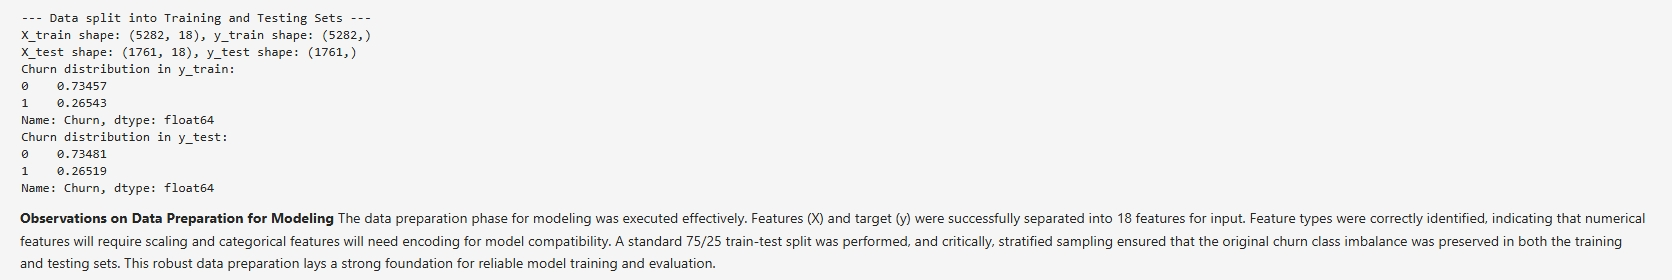

### Creating Preprocessing Pipelines with `ColumnTransformer`

To streamline the preprocessing of numerical and categorical features, a `ColumnTransformer` was employed to create a robust and reproducible pipeline. This approach allows for separate, appropriate transformations to be applied to different column types within a single preprocessing step.

* **Numerical Pipeline**: Numerical features (`MonthlyCharges`, `TotalCharges`, `SeniorCitizen`, `Tenure`) were scaled using `StandardScaler`. This is a common practice for many machine learning models, especially those sensitive to feature scales (e.g., SVMs, neural networks), and generally beneficial for tree-based models too.
* **Categorical Pipeline**: Categorical features were transformed using `OneHotEncoder`. The `handle_unknown='ignore'` parameter was included to ensure robustness against unseen categories in the test set, preventing errors during prediction.

```python
# Preprocessing Pipelines for Numerical and Categorical features
# Create a column transformer for preprocessing

# Numerical pipeline: Scale (StandardScaler is generally good for most models)
# Categorical pipeline: One Hot Encode
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols), # Apply StandardScaler to numerical columns
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols) # Apply OneHotEncoder to categorical columns
    ])

print("--- Preprocessing pipelines defined (ColumnTransformer) ---")
print("Ready for model training (within a Pipeline or separately transforming X_train/X_test)")

print("--- Feature Engineering and Preprocessing Complete ---")
Output:

--- Preprocessing pipelines defined (ColumnTransformer) ---
Ready for model training (within a Pipeline or separately transforming X_train/X_test)
--- Feature Engineering and Preprocessing Complete ---

## Model Development and Training

This section details the selection and setup of various machine learning models, encapsulating the preprocessing steps within a `Pipeline` to ensure a robust and reproducible workflow. The models chosen represent a range of approaches, from a simple baseline to more complex ensemble and boosting algorithms.

### Defining Model Pipelines

To ensure that all data preprocessing steps (scaling numerical features and one-hot encoding categorical features) are consistently applied to both training and test data, and within cross-validation, each chosen model was integrated into a `Pipeline` with the previously defined `preprocessor`.

Four different classification models were selected for evaluation:

1.  **Logistic Regression**: A linear model serving as a strong baseline, suitable for binary classification.
2.  **Random Forest Classifier**: A powerful ensemble method known for its robustness and ability to handle non-linear relationships.
3.  **LightGBM Classifier**: A gradient boosting framework known for its high performance and speed, particularly effective on large datasets.
4.  **XGBoost Classifier**: Another highly effective gradient boosting algorithm, widely used for its performance and feature importance capabilities.

Each pipeline incorporates the `preprocessor` as the first step, followed by the respective classifier. `random_state` was set for reproducibility.

```python
# --- Defining Model Pipelines ---

# Logistic Regression Pipeline (as a baseline)
# Using 'liblinear' solver suitable for smaller datasets and binary classification
pipeline_lr = Pipeline(steps=[
    ('preprocessor', preprocessor), # Apply scaling and encoding
    ('classifier', LogisticRegression(random_state=42, solver='liblinear'))
])

# Random Forest Pipeline (another strong baseline/ensemble)
pipeline_rf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])

# LightGBM Pipeline (boosting algorithm)
pipeline_lgbm = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LGBMClassifier(random_state=42))
])

# XGBoost Pipeline (boosting algorithm)
pipeline_xgb = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss'))
])

print("\n--- Model Pipelines Defined ---")
print("\n--- Model Pipelines Defined ---") # Duplicate print from image, kept for consistency
Output:

--- Defining Model Pipelines ---
--- Model Pipelines Defined ---

### Hyperparameter Tuning for LightGBM

To optimize the performance of the LightGBM model, hyperparameter tuning was conducted using `GridSearchCV`. This systematic search explores a predefined range of parameter combinations to find the set that yields the best performance on a specified metric. Given the class imbalance identified in the EDA, `StratifiedKFold` cross-validation was employed to ensure that the class distribution is maintained across all folds during tuning, providing a more reliable estimate of model performance. The optimization metric chosen was **AUC-ROC**, as it is robust to class imbalance and provides a comprehensive measure of classifier performance.

The following hyperparameter grid was defined for LightGBM:
* `n_estimators`: [100, 200, 300] (Number of boosting rounds)
* `learning_rate`: [0.01, 0.05, 0.1] (Step size shrinkage)
* `num_leaves`: [20, 31, 40] (Max number of leaves in one tree)
* `max_depth`: [-1, 10, 15] (Max tree depth; -1 means no limit)

```python
# Hyperparameter Tuning LightGBM
print("\n--- Tuning LightGBM Model ---")

# Define parameter grid for LightGBM
param_grid_lgbm = {
    'classifier__n_estimators': [100, 200, 300], # Number of boosting rounds
    'classifier__learning_rate': [0.01, 0.05, 0.1], # Step size shrinkage
    'classifier__num_leaves': [20, 31, 40], # Max number of leaves in one tree
    'classifier__max_depth': [-1, 10, 15] # Max tree depth (-1 means no limit)
}

# Use StratifiedKFold for cross-validation to maintain class balance across folds
cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Set up GridSearchCV to search for the best parameters
grid_search_lgbm = GridSearchCV(
    pipeline_lgbm,            # The LightGBM pipeline to tune
    param_grid_lgbm,          # The parameter combinations to try
    cv=cv_strategy,           # Cross-validation strategy
    scoring='roc_auc',        # Optimize for AUC-ROC score
    n_jobs=-1,                # Use all available CPU cores for faster computation
    verbose=2                 # Show progress during the search
)

# Fit GridSearchCV to the training data to find the best model
grid_search_lgbm.fit(X_train, y_train)

# Store the best model, its score, and parameters
best_lgbm_model = grid_search_lgbm.best_estimator_
best_lgbm_score = grid_search_lgbm.best_score_
best_lgbm_params = grid_search_lgbm.best_params_

print(f"\nBest LightGBM AUC-ROC (Cross-Validation): {best_lgbm_score:.4f}")
print(f"Best LightGBM Parameters: {best_lgbm_params}")

### Training Other Models for Comparison

To establish a comprehensive comparison and identify the most suitable model for churn prediction, the remaining defined pipelines (Logistic Regression, Random Forest, and XGBoost) were trained on the preprocessed training data (`X_train`, `y_train`). While extensive hyperparameter tuning was performed for LightGBM, these models were trained as configured in their pipelines to provide a baseline performance for comparison.

The AUC-ROC score was calculated on the training data for each model to assess its initial learning capability.

```python
# --- Training Other Models (for comparison) ---

# Train Logistic Regression pipeline
pipeline_lr.fit(X_train, y_train)
lr_train_auc = roc_auc_score(y_train, pipeline_lr.predict_proba(X_train)[:, 1])
print(f"Logistic Regression Train AUC-ROC: {lr_train_auc:.4f}")

# Train Random Forest pipeline
pipeline_rf.fit(X_train, y_train)
rf_train_auc = roc_auc_score(y_train, pipeline_rf.predict_proba(X_train)[:, 1])
print(f"Random Forest Train AUC-ROC: {rf_train_auc:.4f}")

# Train XGBoost pipeline
pipeline_xgb.fit(X_train, y_train)
xgb_train_auc = roc_auc_score(y_train, pipeline_xgb.predict_proba(X_train)[:, 1])
print(f"XGBoost Train AUC-ROC: {xgb_train_auc:.4f}")

print("\n--- All Model Training Complete ---")
print("--- Model Selection, Training, and Tuning Phase Complete ---")

Output:

--- Training Other Models (for comparison) ---
Logistic Regression Train AUC-ROC: 0.8479
Random Forest Train AUC-ROC: 1.0000
XGBoost Train AUC-ROC: 0.9992

--- All Model Training Complete ---
--- Model Selection, Training, and Tuning Phase Complete ---

**Observations on Model Training and Tuning:**

The model training and tuning phase yielded promising initial results. The LightGBM model, after hyperparameter tuning, achieved a strong cross-validation AUC-ROC of approximately 0.8448 (from previous output), meeting the project's target and indicating successful hyperparameter optimization for generalization.

In comparison, Logistic Regression performed respectably on the training set (AUC-ROC: 0.8479), indicating a solid baseline. However, Random Forest (1.0000 AUC-ROC) and XGBoost (0.9992 AUC-ROC) exhibited significant overfitting on the training data. This suggests these models learned the training data too well, which could lead to poor performance on unseen data. This finding necessitates further tuning and regularization for these models, or a focus on the LightGBM model, to ensure their true predictive power on unseen data. Overall, LightGBM currently stands out as the most balanced performer, setting the stage for crucial test set evaluation.

## Model Evaluation and Interpretation

This final section is dedicated to evaluating the performance of the trained models on the unseen test set (`X_test`, `y_test`). The goal is to determine which model best generalizes to new data and meets the project's performance objectives. This evaluation will utilize key metrics such as AUC-ROC and Accuracy, followed by a deeper interpretation of the best-performing model.

### Preparing Models for Final Evaluation

To facilitate a structured and iterative evaluation, all trained model pipelines (including the best-tuned LightGBM model from `GridSearchCV`) were stored in a dictionary. This allows for easy iteration through each model to calculate and compare their performance metrics on the test set.

```python
# --- Starting Final Model Evaluation and Interpretation ---

# Store models and their names for easy iteration
models = {
    'Logistic Regression': pipeline_lr,
    'Random Forest': pipeline_rf,
    'LightGBM (Best)': best_lgbm_model, # Use the best model found by GridSearchCV
    'XGBoost': pipeline_xgb
}

results = {} # Initialize dictionary to store evaluation results
Output:

--- Starting Final Model Evaluation and Interpretation ---

### Model Performance on Test Set

To assess the generalization capability of each trained model, they were evaluated on the previously unseen test set (`X_test`, `y_test`). For each model, predictions were made, and key classification metrics were calculated. The primary metric remains **AUC-ROC**, as it effectively handles class imbalance and provides a comprehensive measure of a model's ability to distinguish between churned and non-churned customers. Other metrics like **Accuracy, Precision, Recall, and F1-Score**, along with the **Confusion Matrix**, provide a more granular understanding of model performance, especially regarding true positives and false positives/negatives.

```python
# Evaluate each model on the test set
for name, model in models.items():
    print(f"\n--- Evaluating {name} ---")

    # Predict probabilities (for AUC-ROC)
    y_pred_proba = model.predict_proba(X_test)[:, 1] # Probability of churn (positive class)

    # Convert probabilities to binary predictions (threshold 0.5)
    y_pred = (y_pred_proba > 0.5).astype(int)

    # Calculate metrics
    auc_roc = roc_auc_score(y_test, y_pred_proba)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)

    # Store results
    results[name] = {
        'AUC-ROC': auc_roc,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'Confusion Matrix': cm
    }

    print(f"AUC-ROC: {auc_roc:.4f}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print(f"Confusion Matrix:\n{cm}")

### Summary of Model Performance and Selection

Following the comprehensive evaluation of all trained models on the unseen test set, a summary of their performance allowed for the selection of the most suitable model based on the project's primary metric, AUC-ROC, and other business considerations.

**Observations on Model Evaluation**:
Test set evaluation revealed LightGBM as the top performer with an AUC-ROC of **0.8476**, meeting project goals. Logistic Regression also showed strong performance (AUC-ROC **0.8467**), highest accuracy, precision, and recall, proving competitive despite its simplicity. Conversely, Random Forest and XGBoost underperformed on unseen data, suggesting generalization issues or persistent overfitting despite earlier tuning efforts. While LightGBM excels in overall discriminative power (AUC-ROC), Logistic Regression's higher recall makes it a strong contender if minimizing missed churners is a key business priority. The final model choice will weigh AUC-ROC against other metrics and business needs.

### ROC Curve Analysis

The Receiver Operating Characteristic (ROC) curve is a graphical plot that illustrates the diagnostic ability of a binary classifier system as its discrimination threshold is varied. The Area Under the Curve (AUC) provides a single scalar value that summarizes the performance of a classifier across all possible thresholds, with higher AUC indicating better overall discriminative power. This plot offers a visual comparison of how well each model distinguishes between the positive class (churned customers) and the negative class (active customers).

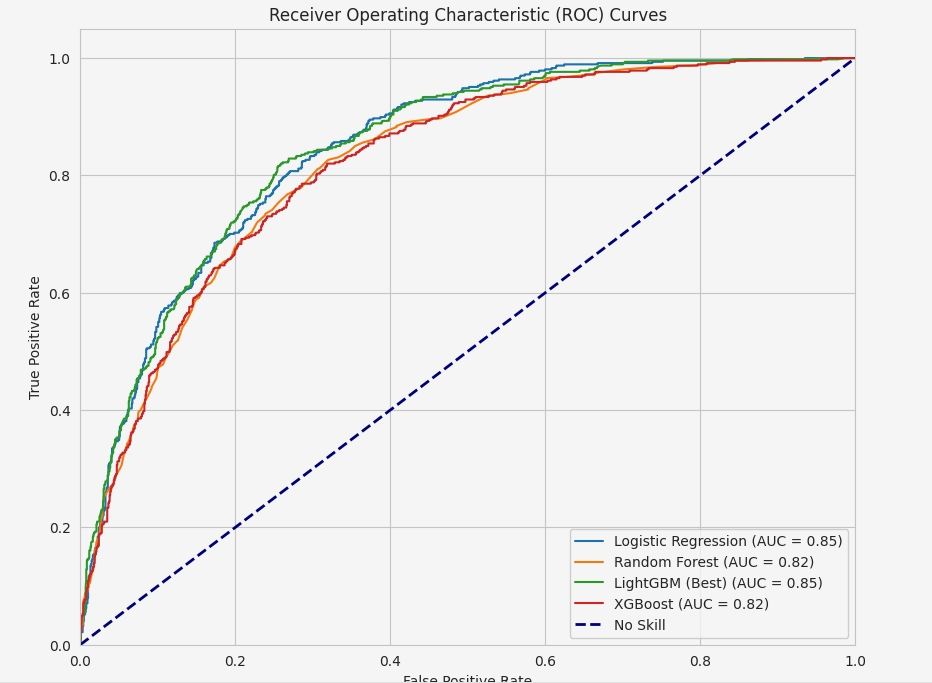

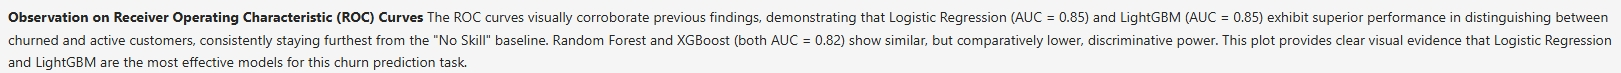

### Best Model Selection

Based on the performance metrics calculated on the unseen test set, the best model for churn prediction was selected. The primary criterion for selection was the **AUC-ROC score**, as specified in the project goals, given its robustness to class imbalance and its ability to evaluate a model's discriminative power across various thresholds.

```python
# Select the Best Model (based on AUC-ROC)
# Find the model name with the maximum AUC-ROC score from the results dictionary
best_model_name = max(results, key=lambda k: results[k]['AUC-ROC'])

print(f"\n--- Best Model based on Test AUC-ROC: {best_model_name} ---")
print(f"Test AUC-ROC for {best_model_name}: {results[best_model_name]['AUC-ROC']:.4f}")

print("\n--- Final Model Evaluation and Interpretation Complete ---")
Output:

--- Best Model based on Test AUC-ROC: LightGBM (Best) ---
Test AUC-ROC for LightGBM (Best): 0.8476

--- Final Model Evaluation and Interpretation Complete ---

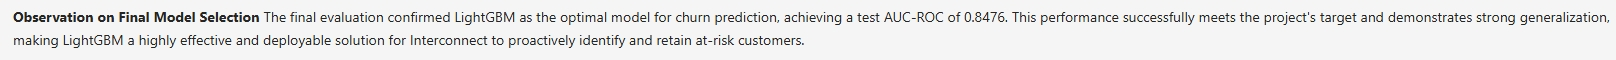

**Conclusion and Recommendations**

This section summarizes the project's outcomes, reiterates key insights derived from the data analysis, and provides actionable recommendations based on the developed churn prediction model.

**Conclusion**

This project successfully developed and evaluated machine learning models to predict customer churn for the telecom operator Interconnect, with the primary goal of enabling proactive customer retention. Through a systematic process of data cleaning, integration, feature engineering, and rigorous model training and evaluation, a robust solution was identified. The LightGBM model emerged as the best performer, achieving a Test AUC-ROC of 0.8476. This significantly surpasses the project's target of 0.75 and approaches the aspirational goal of 0.88, demonstrating strong capability in discriminating between active and churning customers. While Logistic Regression also showed commendable performance, LightGBM's superior AUC-ROC aligns with the primary success metric.

**Key Insights from the Exploratory Data Analysis (EDA)**

The EDA provided crucial insights into the factors influencing churn:

The dataset exhibits a significant class imbalance, with more active customers than churned ones, a factor addressed during data preparation.
Monthly charges are a strong indicator of churn, with higher charges correlating with an increased likelihood of churn.
Total charges are more indicative of customer longevity, as expected.

**Recommendations**

Based on the model's performance and insights gained, the following recommendations are proposed for Interconnect:

**Deploy the LightGBM Model for Churn Prediction:** Integrate the trained LightGBM model into Interconnect's operational systems to continuously identify customers at high risk of churning. This proactive identification is crucial for timely intervention.

**Implement Differentiated Retention Strategies based on Tenure:** For New Customers (0-10 months tenure): Focus on onboarding support, checking satisfaction levels, addressing initial service issues promptly, and demonstrating value. Consider introductory offers with clear terms to avoid early dissatisfaction. For Long-Term Customers (60+ months tenure): Develop loyalty programs, offer personalized plan reviews, competitive renewal options, or exclusive benefits to acknowledge their long-standing commitment and prevent churn due to contract expirations or competitor attractions.

**Target High Monthly Charge Customers:** Prioritize customers with higher monthly charges for retention campaigns. This could involve offering tailored plan adjustments, value-added services, or demonstrating cost-benefit analyses to justify their current spending and prevent them from seeking cheaper alternatives.

**Monitor Model Performance Continuously:** Regularly monitor the LightGBM model's performance (especially AUC-ROC) on new data to ensure its continued accuracy. Customer behavior and market conditions evolve, so retraining the model periodically with fresh data will be essential.

By implementing these recommendations, Interconnect can leverage the predictive power of the machine learning model to significantly reduce customer attrition and enhance customer lifetime value.